### **Topic Modelling on Disneyland Reviews (Paris).**

Our analysis involves customer reviews and ratings from three Disney branches. Customers have rated their experiences on a scale of 1 to 5, with ratings of 1 to 3 indicating negative review and ratings of 4 and 5 indicating positive review.

We will conduct separate topic modeling analyses on the positive and negative reviews for each branch. Our aim is to identify the topics that are contributing to positive feedback and attracting customers, as well as the topics that are leading to negative feedback.Identifying the positive aspects will help us understand the reasons for customer footfall and identifying the negative aspects will enable us to address the issues and improve the overall customer experience.

We aim to perform Topic modeling for each branch, extracting topics on a monthly and seasonal basis. Our aim was to explore how the topics discussed by people are influenced by the month or season

Our ultimate goal is to help the Disneyland authorities address customer feedback and improve their services.

**We will be focussing on Disneyland Paris in this notebook**

### **Research questions**

1. a. What are the key topics mentioned in positive customer reviews of Disneyland Paris<BR>
   b. Key topics mentioned in negative customer reviews of Disneyland Paris
2. How do these topics vary across different months in Disneyland Paris.
3. How do these topics vary across different seasons in Disneyland Paris.
4. How can this information be used to enhance the customer experience and address any issues affecting customer satisfaction.

### **Table of contents**


1. **Topic Modeling for Paris**<br>
    a. For Positive Reviews<br>
    b. For Negative Reviews<br>
2. **Topics across different months** : Learn k topics across all the reviews and then compute average topic distribution month by month.See change in topic distribution and analyze the reason<br>
3. **Topics across different seasons** : Learn k topics across all the reviews and then compute average topic distribution across season.See change in topic distribution and analyze the reason<br>
4. **Suggestions for Disneyland Paris**

#### Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import names 
import random
import nltk 
import calendar
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import pandas as pd
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
import re
from nltk.corpus import treebank
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from gensim import corpora
import gensim
from gensim.models.coherencemodel import CoherenceModel

### Reading Data and Data Preprocessing

In [21]:
reviews_df = pd.read_csv('/Users/aasthatandon/Library/Mobile Documents/com~apple~CloudDocs/CSUEB materials/Spring 2023/BAN 676/Project/BAN675/Team Project/Data/DisneylandReviews.csv', encoding='latin-1')
reviews_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


##### Branch

In [22]:
reviews_df['Location'] = reviews_df.Branch.str[11:]
reviews_df.drop(columns="Branch", inplace=True)
reviews_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Location
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",HongKong


##### Removing Missing Year_Month

In [23]:
#To select rows whose column value equals 'missing' in 'Year_Month':
missing = reviews_df.loc[reviews_df['Year_Month'] == 'missing']
#keep the missing rows seperate
reviews_df = reviews_df[reviews_df.Year_Month != 'missing']
reviews_df.shape

(40043, 6)

##### Extracting Year and Month

In [24]:
reviews_df['Year'] = pd.DatetimeIndex(reviews_df['Year_Month']).year
reviews_df['Year'] = pd.to_numeric(reviews_df['Year'])
reviews_df['Month'] = pd.DatetimeIndex(reviews_df['Year_Month']).month
reviews_df['Month'] = pd.to_numeric(reviews_df['Month'])
reviews_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Location,Year,Month
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


In [25]:
reviews_df.drop('Year_Month', axis=1, inplace = True)
reviews_df = reviews_df.reset_index(drop=True)
reviews_df.head(5)

,Review_ID,Rating,Reviewer_Location,Review_Text,Location,Year,Month
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


##### Data Cleaning

In [26]:
# Clean out Disney location references and ride references
reviews_df['Review_Text'] = reviews_df['Review_Text'].str.replace(r"disney(?:land| park)?|park|place|hong kong|hk|cali|california|paris|pa|fr|Disneyland Railroad|\
                            Great Moments with Mr. Lincoln | Lincoln| The Disney Gallery | Gallery| Main Street Vehicles | \
                            Main Street Cinema | Main Street | Walt Disney's Enchanted Tiki Room | Enchanted Tiki Room | Jungle Cruise | \
                            Indiana Jones | Pirates of the Caribbean | Haunted Mansion | \
                            Davy Crockett Explorer Canoes | Davy Crockett | Explorer Canoes | Many Adventures of Winnie the Pooh | Winnie the Pooh | Splash Mountain | \
                            Big Thunder Mountain Railroad | Mark Twain Riverboat | Mark Twain | Frontierland Shootin Exposition |Frontierland| \
                            Pirate's Lair on Tom Sawyer Island | Pirate's Lair | Tom Sawyer | Sailing Ship Columbia | \
                            Mickey's House | Meet Mickey | Minnie's House | Roger Rabbit's Car Toon Spin | Roger Rabbit | \
                            Chip 'n' Dale's Gadget Coaster | Gadget Coaster | Fantasyland Theatre | It's a Small World | Small World | \
                            Mr. Toad's Wild Ride | Peter Pan's Flight | Pinocchio's Daring Journey | Pixie Hollow |\
                            Snow White's Enchanted Wish | Snow White | Enchanted Wish | Storybook Land Canal Boats | Storybook Land| Canal Boats |Dumbo the Flying Elephant | Dumbo |\
                            Casey Jr. Circus Train | Circus Train | Alice in Wonderland | Matterhorn Bobsleds | Bobsleds | King Arthur Carrousel | King Arthur |\
                            Mad Tea Party | Sleeping Beauty Castle Walkthrough | Sleeping Beauty| Astro Orbiter | \
                            Autopia Star Tours – The Adventures Continue | Autopia Star Tours | Buzz Lightyear Astro Blasters | Buzz Lightyear | Astro Blasters |\
                            Space Mountain | Monorail | Finding Nemo Submarine Voyage | Finding Nemo | Submarine Voyage |\
                            Star Wars Launch Bay | Star Wars | Millennium Falcon: Smuggler's Run | Millennium Falcon | Smuggler's Run| Rise of the Resistance | \
                            Electrical Parade | Galaxy's Edge | Tomorrowland | Fantasyland | \
                            Mickey's Toontown | Toontown | Frontierland | Critter Country | New Orleans Square | Adventureland | \
                            Main Street, U.S.A.| toy story | lion king | main street | small world | sce mountain | \
                            story land | king show | mickey mouse | grizzly gulch | mystic manor | \
                            big thunder mountain | chinese new year | slinky dog ride | jungle river cruise | lion king show | \
                            toy story| festival lion king | runaway mine cars | mine cars | iron man |\
                            big grizzly mountain | sunny bay station | small world | mountain runaway mine | \
                            iron man experience | sleeping beauty castle | sce mountain | buzz light year | \
                            big thunder | iron man experience | mickey | minnie | \
                            big grizzley | buzz lightyear | mountain",'')

/var/folders/w4/m7nmrzlx639_9y3p7hm312p40000gn/T/ipykernel_6942/4290222359.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_df['Review_Text'] = reviews_df['Review_Text'].str.replace(r"disney(?:land| park)?|park|place|hong kong|hk|cali|california|paris|pa|fr|Disneyland Railroad|\


In [27]:
common_words1 = ["disneyland","disneyland_Paris","disneyland_HongKong","usa","world",
                 "disneyworld","disney","kong","hong","paris","california","States","park","ok",
                "one","go","get","the", "them", "your","us","lot","day","hk","realli","would","take","also","queue",
                "year","see","land","much","great","visit","time","kid","went","even","around","children","wait",
                "place","attract","ticket","mani","everi","still","back","peopl","etc", "dont","make","take","now","ride","om",
                "like","good","small","ss","comr","could","pari","got","use","euro","florida"
                ]

##### Paris Branch

In [9]:
#Define Paris Branch
paris_df = reviews_df[reviews_df['Location']=='Paris']
paris_df.head()

,Review_ID,Rating,Reviewer_Location,Review_Text,Location,Year,Month
27349,670721950,5,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s...",Paris,2019,3
27350,670686565,4,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...,Paris,2018,6
27351,670606796,5,United Kingdom,"What a fantastic , the queues were decent as t...",Paris,2019,4
27352,670586937,4,Australia,We didn't realise it was school holidays when ...,Paris,2019,4
27353,670400930,5,United Kingdom,Such a magical experience. I recommend making ...,Paris,2019,4


### 1 a. Build the Topic Model for Disneyland Paris Positive Reviews

We will classify 4 and 5 as positives and 1,2,3, as negative reviews and make two list corresponding to them

In [10]:
def sentiment(df):
    pos_reviews=[]
    neg_reviews=[]
    for idx,row in df.iterrows():
        if row['Rating']==4 or row['Rating']==5:
            pos_reviews.append(row['Review_Text'])
        else:
            neg_reviews.append(row['Review_Text'])
    return pos_reviews,neg_reviews

In [11]:
paris_pos_reviews, paris_neg_reviews = sentiment(paris_df)
paris_pos_reviews[0]

"We've been to Disneyland Hongkong and Tokyo, so far this one is the best. We're looking forward to visit the biggest one in Orlando. 1 day is not enough, it is recommended to stay in Disney Hotel   Resort so you can enjoy the fast track.. save huge amount of time.. if you're not staying there, plan and strategize your visit by getting all the fast track sses om kiosk nearby the attraction; then come back when it's time for your ride. The projection and fireworks show are out of this world!!"

In [13]:
###  select the number of topics ###check on this 
stop = stopwords.words('english')
def clean(doc):
    """
    Clean review
    args:
        doc: review (stry type)
    returns:
        cleaned review
    """
    stemmer=PorterStemmer()
    lowercase=[i.lower() for i in nltk.word_tokenize(doc) if i.lower() not in stop and i.isalpha()] 
    normalized=[stemmer.stem(i) for i in lowercase]
    normalized = [i for i in normalized if i not in common_words1]
    
    return normalized

def grid_search_on_num_topics(reviews, topics = [2,3,4,5,6,7]):
    """
    Do grid search on number of topics for topic modelling.
    args:
        reviews: list of reviews (list of str types)
    returns:
        
    """
    Lda = gensim.models.ldamodel.LdaModel
    contents=[clean(x) for x in reviews]
    dictionary = corpora.Dictionary(contents)
    #preparing data
    doc_term_matrix=[dictionary.doc2bow(doc) for doc in contents]# frequency of words in dict

    for i in topics:
        ldamodel = Lda(
            doc_term_matrix, num_topics=i, id2word = dictionary, passes=50, chunksize=10
        )
        #computing coherence score for the model
        cm = CoherenceModel(model=ldamodel,texts=contents, corpus=doc_term_matrix, coherence='c_v', processes=5)
        coherence = cm.get_coherence()
        print(f"with {i} topics, the coherence is {coherence}" )
        
        # Compute Perplexity
        #perplexity = ldamodel.log_perplexity(doc_term_matrix)
        #print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.
        #print(f"with {i} topics, the coherence is {coherence} , perplexity is {perplexity}" )
        
        # Compute Coherence Score
        #coherence_model_lda22 = CoherenceModel(model=lda_model22, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        #coherence_lda22 = coherence_model_lda22.get_coherence()
        #print('\nCoherence Score: ', coherence_lda22)

# the bigger the coherence, the better the model coherence
# we pick the number of topics that when the increase of coherence score becomes slower



In [14]:
grid_search_on_num_topics(paris_pos_reviews, topics = [2,4,6])

with 2 topics, the coherence is 0.39901405843856547
with 4 topics, the coherence is 0.3817633320060867
with 6 topics, the coherence is 0.35973986451478224


Selecting number of topics to be 2

In [78]:
def topic_model(reviews,num_topics=2):
    Lda = gensim.models.ldamodel.LdaModel
    contents = [clean(x) for x in reviews]
    dictionary = corpora.Dictionary(contents)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in contents]
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary)
    return ldamodel, dictionary


In [79]:
paris_ldamodel_pos, _ = topic_model(paris_pos_reviews,num_topics=2)
print(paris_ldamodel_pos.print_topics(num_topics=2, num_words=10))

[(0, '0.008*"show" + 0.006*"rade" + 0.006*"hotel" + 0.006*"enjoy" + 0.006*"charact" + 0.006*"studio" + 0.005*"want" + 0.005*"close" + 0.005*"love" + 0.005*"hour"'), (1, '0.013*"food" + 0.012*"love" + 0.008*"hotel" + 0.008*"magic" + 0.007*"stay" + 0.007*"show" + 0.007*"expens" + 0.007*"rade" + 0.007*"charact" + 0.006*"worth"')]


In [80]:
#Plot Wordcloud of Top 10 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def topic_wordcloud(ldamodel,num_topics=4):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stop,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)
    row = num_topics//2

    fig, axes = plt.subplots(row, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show();
    

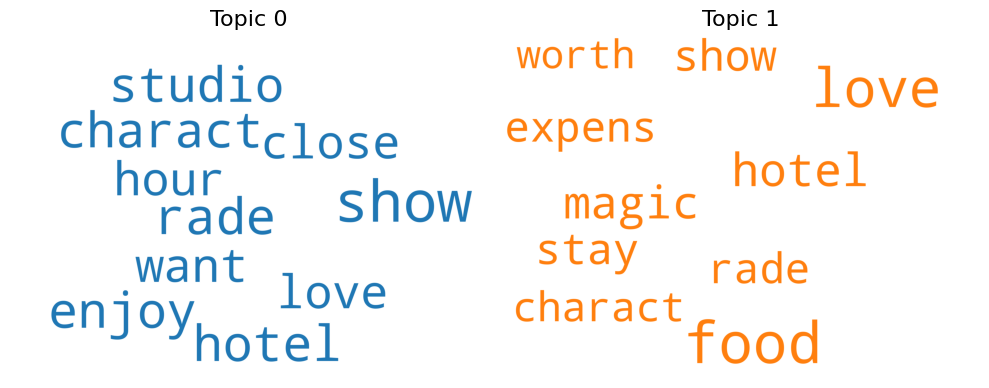

In [81]:
topic_wordcloud(paris_ldamodel_pos,num_topics=2)

Topic 0 : "Unforgettable Memories and Magical Experiences at Disneyland Paris"<BR>

This topic could focus on positive reviews and experiences shared by visitors to Disneyland Paris. It could explore the various aspects of the park that guests enjoyed, such as the rides, shows,hotel stays, and character interactions. The topic mainly about vsitor's great experience.

Topic 1 : "The Culinary Delights of Disneyland Paris"<Br>

This topic could focus on the various dining options available at Disneyland Paris, discussing the different types of cuisine and the great quality of the food. It could also explore the cost of dining at Disneyland Paris and whether the experience is worth the expense. Additionally, it could cover any unique dining experiences available at Disneyland Paris, such as character dining or themed restaurants.

### 1 b. Build the Topic Model for Disneyland Paris Negative Reviews

In [15]:
grid_search_on_num_topics(paris_neg_reviews, topics = [2,4,6])

with 2 topics, the coherence is 0.37033490862509144
with 4 topics, the coherence is 0.31536159632150895
with 6 topics, the coherence is 0.2918623955772698


Selecting number of topics to be 2

In [83]:
paris_ldamodel_neg, _ = topic_model(paris_neg_reviews,num_topics=2)
print(paris_ldamodel_neg.print_topics(num_topics=2, num_words=10))

[(0, '0.009*"hour" + 0.008*"food" + 0.008*"close" + 0.007*"staff" + 0.006*"magic" + 0.006*"minut" + 0.006*"look" + 0.006*"charact" + 0.006*"long" + 0.005*"disappoint"'), (1, '0.009*"food" + 0.008*"staff" + 0.006*"hotel" + 0.006*"experi" + 0.006*"smoke" + 0.006*"minut" + 0.006*"fast" + 0.006*"show" + 0.005*"hour" + 0.005*"charact"')]


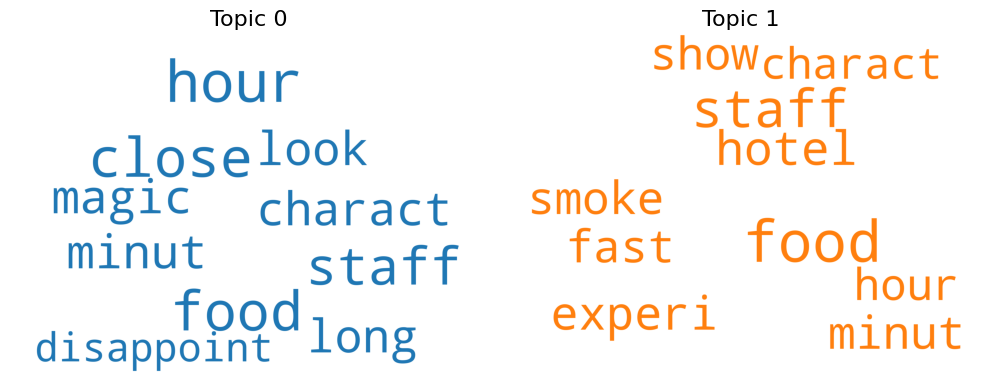

In [84]:
topic_wordcloud(paris_ldamodel_neg,num_topics=2)

Topic 1: Negative Reviews about Restaurant Food and Service

This topic is about negative reviews related to restaurant experiences. Customers might express their dissatisfaction with the food quality, staff being unhelpful or rude, long wait times, feeling rushed to finish their meals or not getting their food served fast enough, or feeling disappointed with their overall experience.

Topic 2: Negative Reviews about Hotel Accommodation

This topic is about negative reviews related to hotel accommodation experiences. Customers might express their dissatisfaction with the hotel's cleanliness, comfort, staff service, or the lack of expected amenities such as a smoke-free environment. Additionally, guests may have negative feedback about their experiences with hotel shows and characters.






### 2. Topics across different months :

Learn k topics across all the reviews and then compute average topic distribution across season.See change in topic distribution and analyze the reason

In [18]:
paris_all_reviews = paris_pos_reviews + paris_neg_reviews
random.shuffle(paris_all_reviews)

In [19]:
grid_search_on_num_topics(paris_all_reviews, topics = [2,4,6])

with 2 topics, the coherence is 0.37222066221515837
with 4 topics, the coherence is 0.3764132535379542
with 6 topics, the coherence is 0.336791480286873


 We will be selecting 4 topics

In [87]:
paris_ldamodel_all, paris_dictionary_all = topic_model(paris_all_reviews,num_topics=4)

In [88]:
print(paris_ldamodel_all.print_topics(num_topics=4, num_words=10))

[(0, '0.012*"charact" + 0.008*"food" + 0.008*"hour" + 0.008*"hotel" + 0.008*"rade" + 0.007*"book" + 0.007*"restaur" + 0.007*"want" + 0.006*"staff" + 0.006*"show"'), (1, '0.011*"close" + 0.008*"magic" + 0.008*"fast" + 0.007*"food" + 0.006*"love" + 0.006*"mountain" + 0.006*"experi" + 0.006*"show" + 0.006*"expect" + 0.006*"charact"'), (2, '0.013*"show" + 0.013*"love" + 0.010*"stay" + 0.010*"hotel" + 0.009*"magic" + 0.009*"food" + 0.008*"old" + 0.008*"enjoy" + 0.007*"amaz" + 0.007*"long"'), (3, '0.008*"food" + 0.008*"staff" + 0.007*"price" + 0.006*"money" + 0.005*"need" + 0.005*"hour" + 0.005*"minut" + 0.005*"servic" + 0.005*"close" + 0.004*"line"')]


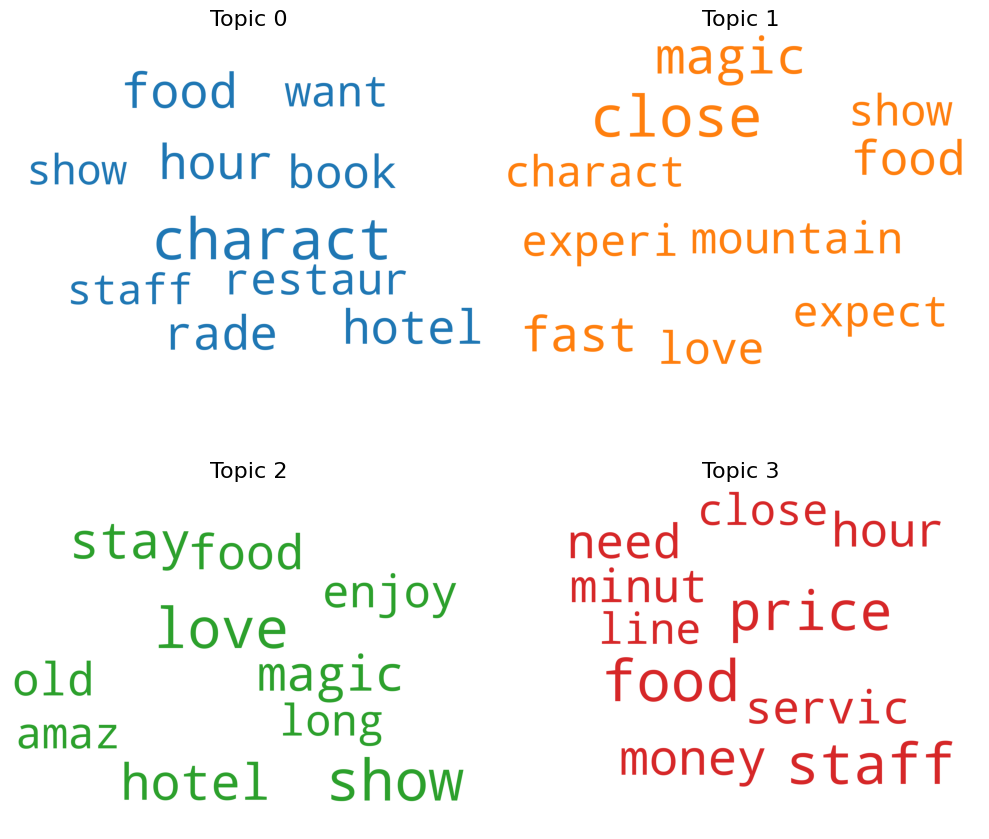

In [89]:
topic_wordcloud(paris_ldamodel_all, num_topics = 4)


Topic 0 : Character Experiences at Disneyland Paris<BR>
The topic discussed the impact of character interactions on visitor satisfaction at Disneyland Paris, with a focus on how these experiences influence return visits and reviews.

Topic 1 : Fast Pass for great overall experiences<BR>
This topic discussed  different attractions at Disneyland Paris and how to maximize the time by using the Fast Pass system.

Topic 2 : Hotel Accommodations and Dining<BR>
This topic talks about the various hotels and restaurants available at Disneyland Paris, including options for different budgets and tastes.

Topic 3 : Tips and Tricks for a Magical Visit<BR>
This topic may talk about the insider tips and advice on how to make the most of your visit to Disneyland Paris, including recommendations for food, shows, attractions, and special events.

Average topic distribution for each month for Paris

In [90]:
def get_reviews_by_month(df):
    month_review = {m:[] for m in range(1,13)}
    for month in month_review:
        mon_true = df['Month'] == month
        reviews = list(df[mon_true]['Review_Text'])
        month_review[month] = reviews
    return month_review

In [91]:
paris_month_reviews = get_reviews_by_month(paris_df)

In [92]:
# write a functon that returns average topic distribution 
def get_avg_topic_dist(ldamodel, dictionary, reviews, num_topics=4):
    review_topic_dist = []
    for review in reviews:
        clean_review = clean(review)
        doc_term_matrix = [dictionary.doc2bow(clean_review)]
        topic_dist = ldamodel.get_document_topics(doc_term_matrix[0]) #get topic distribution
        template_dict=dict.fromkeys(range(num_topics),0) # we need to fill the missing topics in the distribution (missing because the loading is 0), this is to create a template of empty dictionary with all 0 values
        template_dict.update(topic_dist)
        topic_dist = [v for k,v in template_dict.items()]
        review_topic_dist.append(topic_dist)
    
    arr_topic_dist = np.asarray(review_topic_dist)
    review_topic_dist = list(np.mean(arr_topic_dist,axis=0))     
    return review_topic_dist


In [93]:
def plot_avg_topic_dist(avg_topic_dist, prefix=""):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
    num_topics = len(avg_topic_dist)
    ax.bar(range(0, num_topics),avg_topic_dist)
    ax.set_title(prefix + "Average topic distribution")
    ax.set_xlabel("Topic Number")
    ax.set_ylabel("Topic weight")
    ax.set_ylim(0,1)
    ax.set_xticks(range(0, num_topics))
    ax.grid(alpha=0.1)
    plt.show()

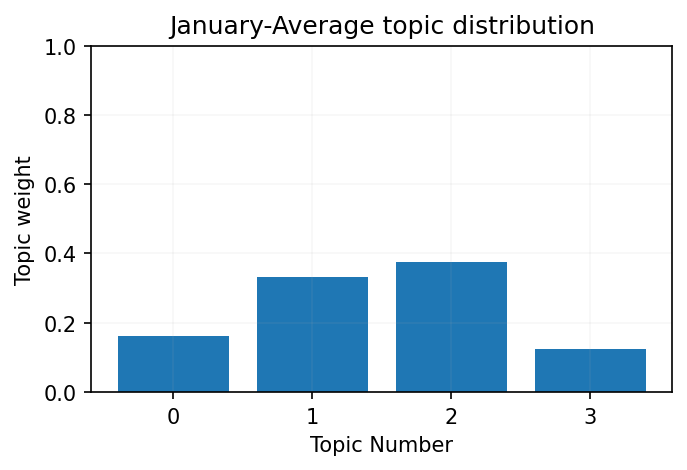

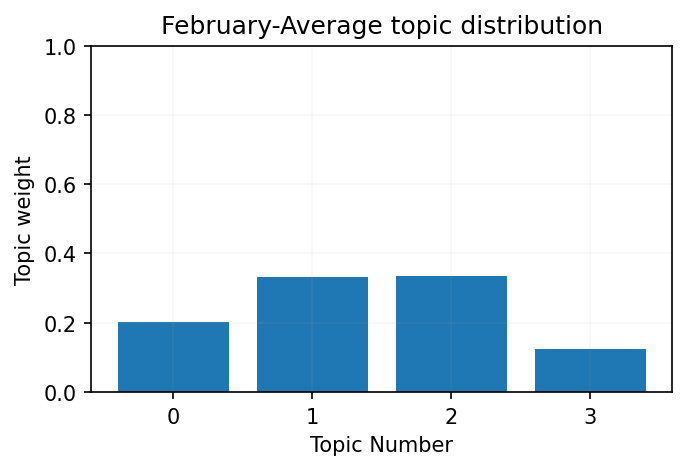

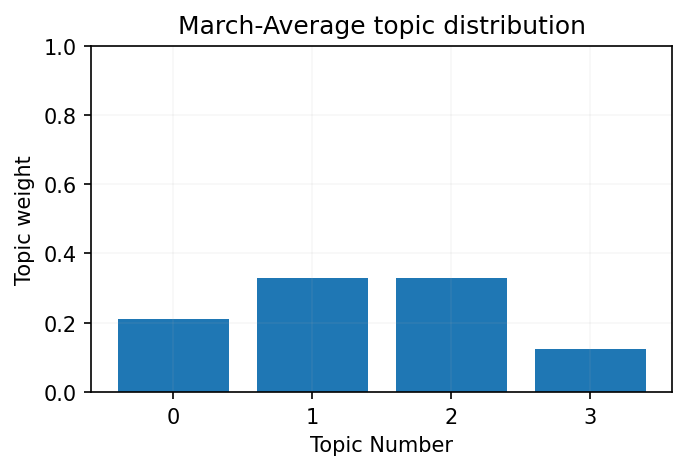

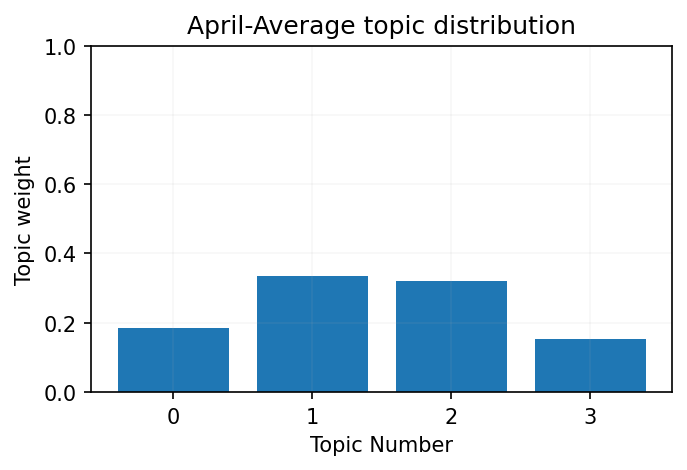

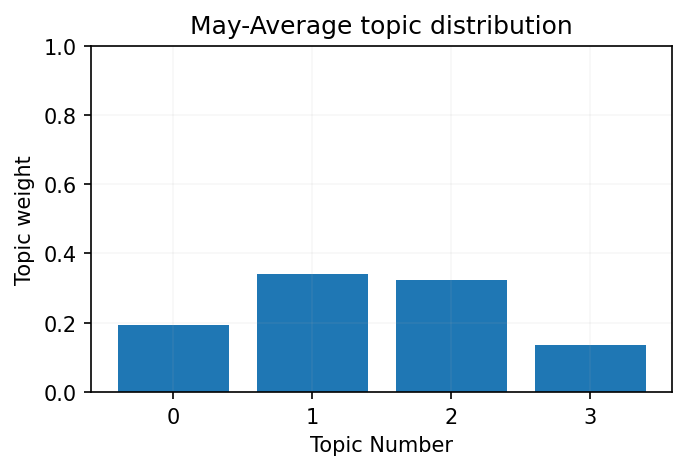

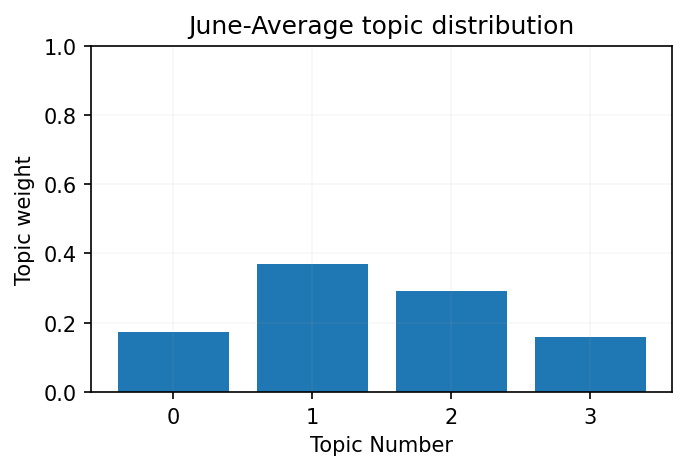

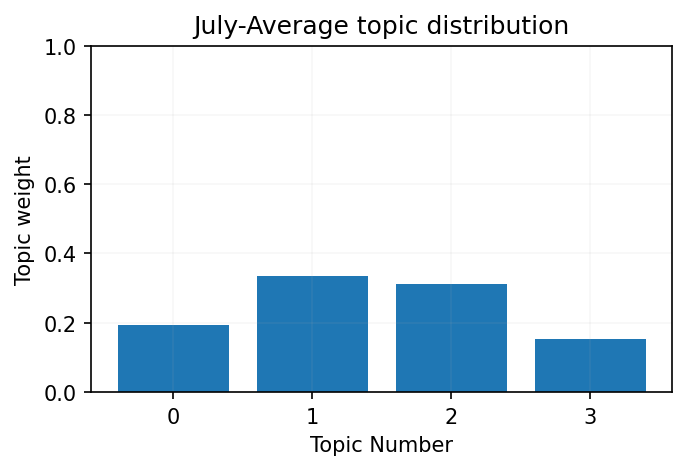

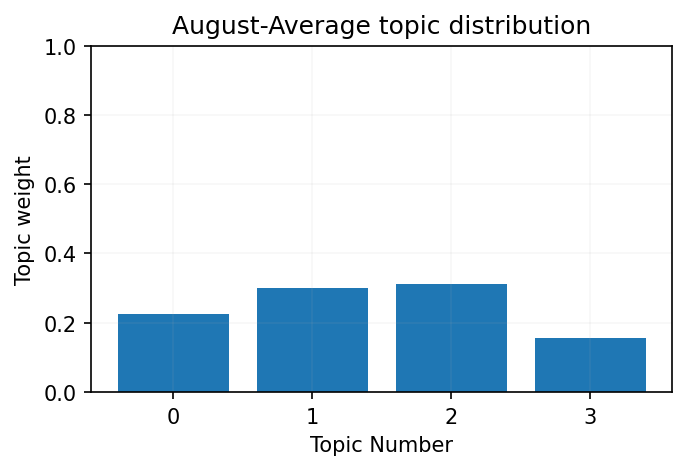

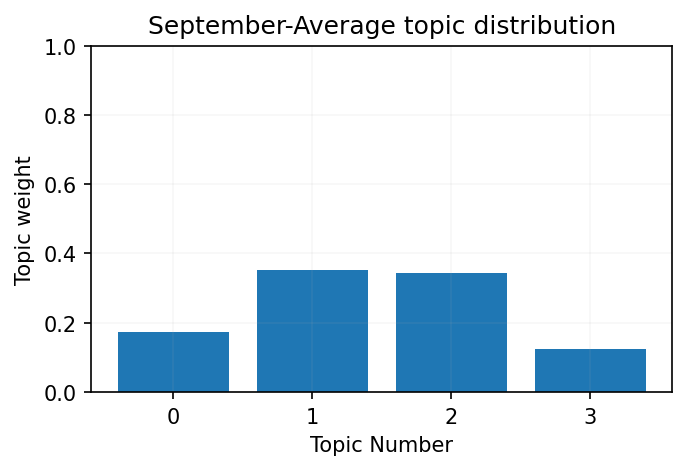

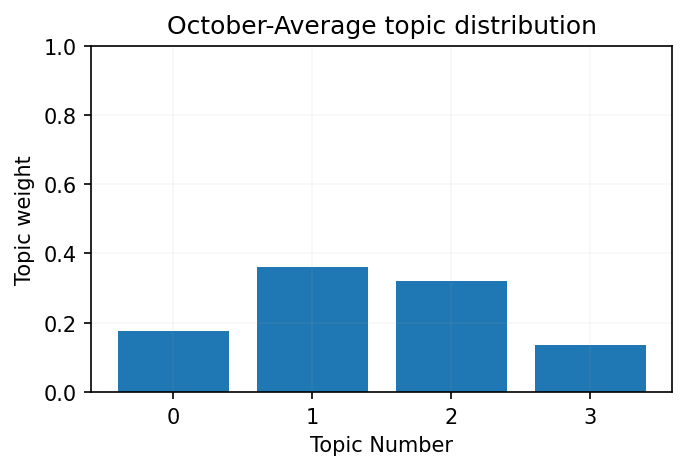

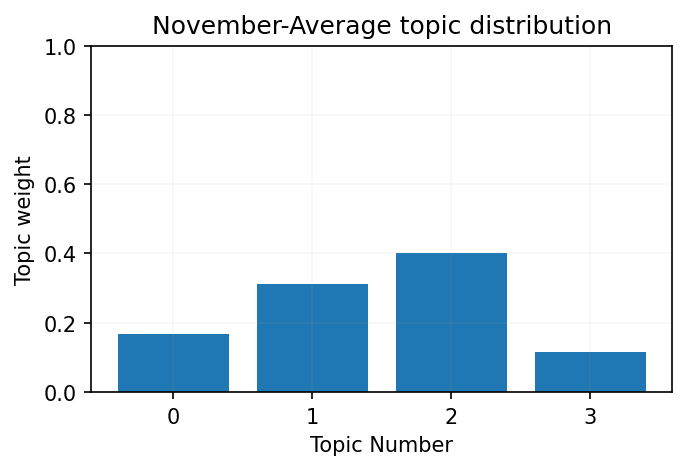

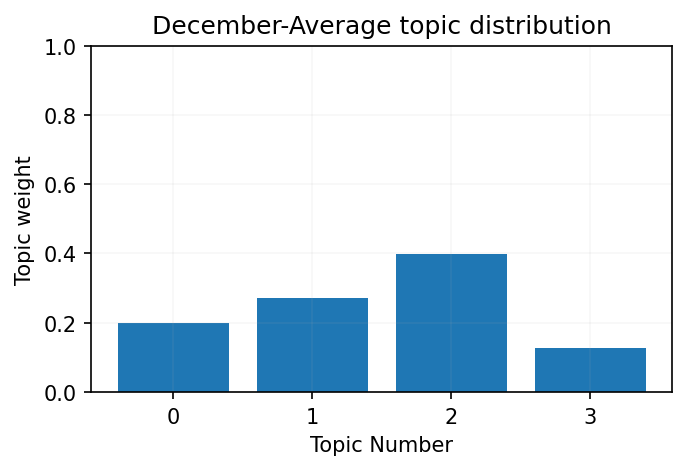

In [94]:
for month,reviews in paris_month_reviews.items():
    avg_topic_dist = get_avg_topic_dist(
        paris_ldamodel_all, paris_dictionary_all , paris_month_reviews[month]
    )
    #print(avg_topic_dist)
    month_string = calendar.month_name[month]
    plot_avg_topic_dist(avg_topic_dist,prefix=month_string + '-')

Topic 3 is least discussed throughout.Topic 2 most discussed in January,August, November and December.
Topic 1 most discussed in April May June July September October.Topic 1 and 2 equally discussed in Feb and March

Topic 2 (Hotel Accommodations and Dining) may be more popular in January, August, November, and December because these are peak travel months due to holidays and school breaks. Visitors may be more interested in planning their accommodations and dining options during these busy times.Topic 1 (Fast Pass and Ride Experiences) may be more popular in the months of April through October because these are typically warmer months and more visitors are likely to be spending time outdoors,enjoying the attractions.

### 3. Topics across different seasons :

Learn k topics across all the reviews and then compute average topic distribution across season.See change in topic distribution and analyze the reason

Average topic distribution for each season for Paris

In [95]:
def get_season_df(df):
    def find_season(month):
        season_month = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Fall', 10:'Fall', 11:'Fall'}
        return season_month.get(month)

    season_list = []
    for month in df['Month']:
        season = find_season(month)
        season_list.append(season)
    df['Season'] = season_list
    return df

In [96]:
def get_reviews_by_season(df):
    df = get_season_df(df)
    season_review = {s:[] for s in ["Summer","Winter","Spring","Fall"]}
    for season in season_review:
        sea_true = df['Season'] == season
        reviews = list(df[sea_true]['Review_Text'])
        season_review[season] = reviews
    return season_review

In [97]:
paris_season_reviews = get_reviews_by_season(paris_df)

/var/folders/w4/m7nmrzlx639_9y3p7hm312p40000gn/T/ipykernel_23921/3732913003.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = season_list


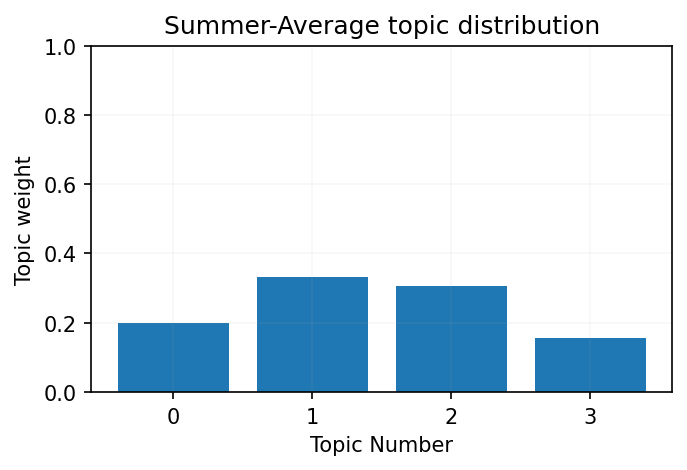

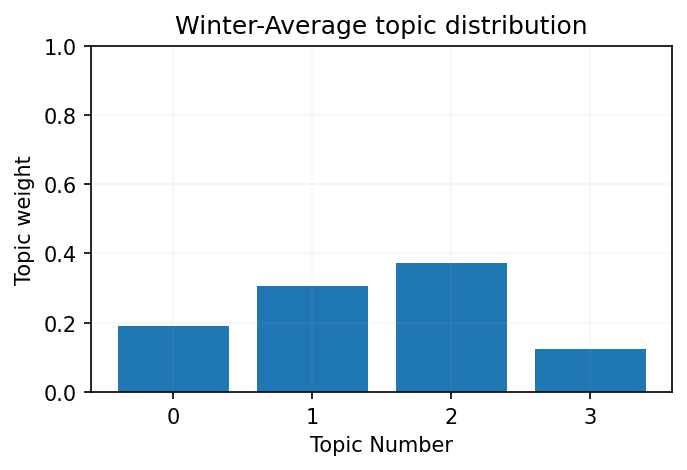

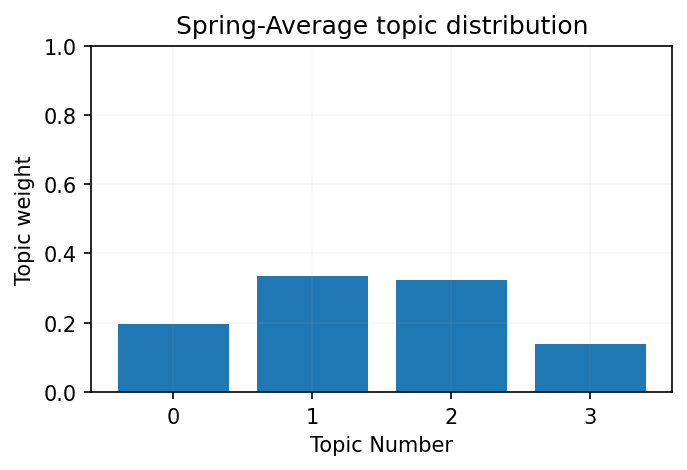

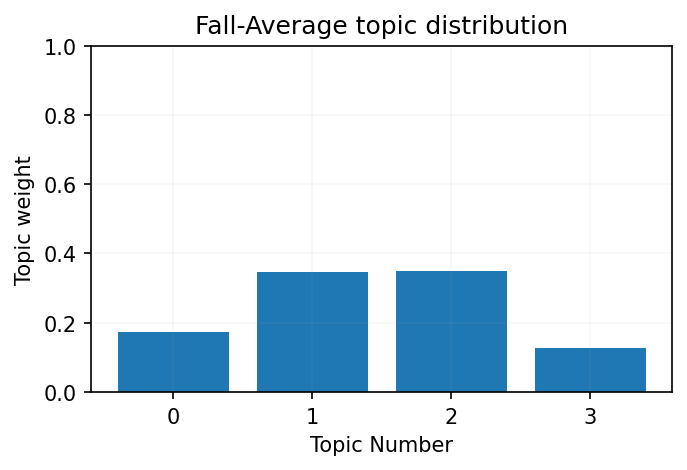

In [98]:
for season,reviews in paris_season_reviews.items():
    avg_topic_dist = get_avg_topic_dist(
        paris_ldamodel_all, paris_dictionary_all , paris_season_reviews[season]
    )
    plot_avg_topic_dist(avg_topic_dist, prefix=season + '-')

Topic 1 slightly more discussed in Summer & Spring than Topic 2 & equally in Fall. Topic 2 most discussed on Winter and Topic 3 is least discussed

Topic 1 (Fast Pass and Ride Experiences) is slighlty more discussed in Summer, Spring than Topic 2 may be because crowd and long lines are major concern for themepark and fastpass can enhance the overall experience.Topic 2 (Hotel Accommodations and Dining) is most discussed during winter as visitors are more focused on indoor experiences, such as dining and staying in hotels. Fall have an equal discussion on both topics due to moderate crowds and a balanced interest in both experiences.

### 4. Suggestions for Disneyland Paris:

Disneyland Paris could improve food quality, staff training, reduce wait times, invest in hotel cleanliness and listen to guest feedback. They could introduce healthier food, a fast pass system, regular deep cleaning, and update amenities. Promotions and events could also be tailored to each season's interests, such as offering more Fast Pass options in summer and promoting unique hotel and restaurant features during winter. Guest feedback can be encouraged through surveys and social media monitoring to ensure visitors have the best experience possible.